In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

torch.manual_seed(0)

Using cuda device


In [3]:
from torch.utils.data._utils.collate import default_collate

def normalize_coords(batch):
    """
    Custom collate function that normalizes the target values in a batch.
    Assumes each element in batch is a tuple (features, target) and target is a tensor of shape (2,)
    with target[0] as x and target[1] as y.
    """

    # Separate features and targets
    features, targets = zip(*batch)

    # Convert lists to PyTorch tensors using default collate
    features = default_collate(features)
    targets = default_collate(targets)

    # Normalize targets
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    targets[..., 0] = (targets[..., 0] - x_min) / (x_max - x_min)  # Normalize x
    targets[..., 1] = (targets[..., 1] - y_min) / (y_max - y_min)  # Normalize y

    return features, targets[:, :-1]

def normalize_yaws(batch):
    features, targets = zip(*batch)

    features = default_collate(features)
    targets = default_collate(targets)

    yaw_min, yaw_max = 0, 285 # for some reason, need to fix

    yaw = (targets[..., 2] - yaw_min) / (yaw_max - yaw_min)

    return features, yaw.unsqueeze(1)

def denormalize_targets(normalized_target):
    """
    Denormalizes the target values from the range [0, 1] back to their original scale.
    Assumes normalized_target is a tensor of shape (..., 2) where normalized_target[..., 0] is x and normalized_target[..., 1] is y.
    """
    # Define the min and max values for x and y
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    # Denormalize x
    x_denormalized = normalized_target[..., 0] * (x_max - x_min) + x_min
    
    # Denormalize y
    y_denormalized = normalized_target[..., 1] * (y_max - y_min) + y_min

    # Combine and return
    return torch.stack([x_denormalized, y_denormalized], dim=-1)


def denormalize_yaws(normalized_target):
    yaw_min, yaw_max = 0, 285

    return torch.stack([normalized_target[..., 0] * (yaw_max - yaw_min) + yaw_min], dim=-1)

In [4]:
# Ablate this model's head, there are 8 to choose from
def ablate_attn(ablate_model, head_idx):
    multihead_attn = ablate_model.attn.attn
    
    num_heads = multihead_attn.num_heads
    head_size = multihead_attn.embed_dim // num_heads
    
    # Calculate the start and end indices for the weights associated with the head
    start_index = head_idx * head_size
    end_index = (head_idx + 1) * head_size
    
    with torch.no_grad():
        # queries
        multihead_attn.in_proj_weight[start_index:end_index, :] = 0
        # keys
        multihead_attn.in_proj_weight[(start_index + multihead_attn.embed_dim):(end_index + multihead_attn.embed_dim), :] = 0
        # values
        multihead_attn.in_proj_weight[(start_index + 2 * multihead_attn.embed_dim):(end_index + 2 * multihead_attn.embed_dim), :] = 0
    
        # Total ablation (including output weights)
        # consider varying this 
        multihead_attn.out_proj.weight[:, start_index:end_index] = 0

In [5]:
# Load in the coordinate data
data_dir = 'data/noisy'

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

dataset = HeadingPredCoordDataset(source_directory=data_dir, transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=normalize_yaws)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=normalize_yaws)

97143 training samples


In [6]:
# Set up the model, which takes as input my trained predictive coder encoder and attn
device = 'cuda' if torch.cuda.is_available() else "cpu"

latent_model_file = 'model_files/faceforward_noisy_83143_samples-200ep-causal.pt'
latent_model = PredictiveCoderWithHead()
latent_model.load_state_dict(torch.load(latent_model_file))

ablate_idx = 2
ablate_attn(latent_model, ablate_idx)

latent_model.to(device)
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False

In [7]:
loc_predictor_file = latent_model_file[:-3] + f'_predictor_hd_ablate_{ablate_idx}.pt'
print(loc_predictor_file)

model = PostPredictionHDPredictor(latent_model, input_dim=144, hidden_dim=250)
model.to(device)

num_epochs = 5
steps_per_epoch = len(train_loader)

learning_rate = 0.01
weight_decay = 0.0001

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

model_files/faceforward_noisy_83143_samples-200ep-causal_predictor_hd_ablate_2.pt


In [8]:
train_losses_file = f'logs/ablated-{ablate_idx}-noisy-hdpred-train-200-ep-5ep.txt'
test_losses_file = f'logs/ablated-{ablate_idx}-noisy-hdpred-test-200-ep-5ep.txt'

train_losses = []
test_losses = []
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train_heading(train_loader, model, loss_fn, optimizer, device)
        test_loss = test_heading(test_loader, model, loss_fn, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        torch.save(model.state_dict(), loc_predictor_file)

finally:
    torch.save(model.state_dict(), loc_predictor_file)
    
    with open(train_losses_file, 'w') as fp:
        for s in train_losses:
            fp.write("%s\n" % s)
            
    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)
    
    print("Done!")


Epoch 1
-------------------------------
loss: 0.254627  [    0/97143]
loss: 0.106663  [ 2000/97143]
loss: 0.048488  [ 4000/97143]
loss: 0.075815  [ 6000/97143]
loss: 0.079968  [ 8000/97143]
loss: 0.170424  [10000/97143]
loss: 0.069560  [12000/97143]
Test Error: 
 Avg loss: 0.066064 

Epoch 2
-------------------------------
loss: 0.051180  [    0/97143]
loss: 0.037552  [ 2000/97143]
loss: 0.057597  [ 4000/97143]
loss: 0.059507  [ 6000/97143]
loss: 0.042291  [ 8000/97143]
loss: 0.035037  [10000/97143]
loss: 0.101319  [12000/97143]
Test Error: 
 Avg loss: 0.047943 

Epoch 3
-------------------------------
loss: 0.041102  [    0/97143]
loss: 0.050937  [ 2000/97143]
loss: 0.025188  [ 4000/97143]
loss: 0.014090  [ 6000/97143]
loss: 0.025362  [ 8000/97143]
loss: 0.057132  [10000/97143]
loss: 0.032048  [12000/97143]
Test Error: 
 Avg loss: 0.042381 

Epoch 4
-------------------------------
loss: 0.030314  [    0/97143]
loss: 0.048614  [ 2000/97143]
loss: 0.047752  [ 4000/97143]
loss: 0.038696 

## Analyze the ablated model's predictive capacity

In [9]:
latent_model_file = 'model_files/faceforward_noisy_83143_samples-200ep-causal.pt'
latent_model = PredictiveCoderWithHead()
latent_model.load_state_dict(torch.load(latent_model_file))#, map_location=torch.device(device)))
ablate_attn(latent_model, ablate_idx)
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False
latent_model.to(device)

model = PostPredictionHDPredictor(latent_model, hidden_dim=250)
model.load_state_dict(torch.load(loc_predictor_file))

model.to(device)
model.eval()

PostPredictionHDPredictor(
  (latent): PredictiveCoderWithHead(
    (encoder): ResNet18Enc(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): Sequential(
        (0): BasicBlockEnc(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential()
        )
        (1): BasicBlockEnc(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (c

In [10]:
## Visualize predicted head direction
from collections import defaultdict

model.eval()
for param in model.parameters():
    param.requires_grad = False

predictions_sum = defaultdict(lambda: [torch.zeros(1), 0])

with torch.no_grad():
    for seq, actual_yaws in test_loader:
        frames, headings = seq
        frames, headings, actual_yaws = frames.to(device), headings.to(device), actual_yaws.to(device)
        predictions = model(frames, headings)
        for actual, pred in zip(actual_yaws, predictions):
            denorm_actual = denormalize_yaws(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count

    for seq, actual_yaws in train_loader:
        frames, headings = seq
        frames, headings, actual_yaws = frames.to(device), headings.to(device), actual_yaws.to(device)
        predictions = model(frames, headings)

        for actual, pred in zip(actual_yaws, predictions):
            denorm_actual = denormalize_yaws(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count
            
# Calculate the average predicted yaw for each actual yaw
average_predictions = {actual: denormalize_yaws(sum_pred[0] / sum_pred[1]) for actual, sum_pred in predictions_sum.items()}

# Example: Print the average predicted yaw for each actual yaw
for actual_location, average_pred in average_predictions.items():
    print(f"Actual Yaw: {actual_location}, Average Predicted Yaw: {average_pred.numpy()}")


Actual Yaw: (98.0,), Average Predicted Yaw: [85.20799]
Actual Yaw: (273.0,), Average Predicted Yaw: [222.58327]
Actual Yaw: (7.0,), Average Predicted Yaw: [23.011103]
Actual Yaw: (189.0,), Average Predicted Yaw: [160.95929]
Actual Yaw: (99.0,), Average Predicted Yaw: [85.939095]
Actual Yaw: (184.0,), Average Predicted Yaw: [152.30989]
Actual Yaw: (284.0,), Average Predicted Yaw: [220.13895]
Actual Yaw: (92.0,), Average Predicted Yaw: [73.68333]
Actual Yaw: (1.0,), Average Predicted Yaw: [39.556362]
Actual Yaw: (283.0,), Average Predicted Yaw: [223.56454]
Actual Yaw: (10.0,), Average Predicted Yaw: [25.435144]
Actual Yaw: (101.0,), Average Predicted Yaw: [89.81747]
Actual Yaw: (183.0,), Average Predicted Yaw: [149.84354]
Actual Yaw: (191.0,), Average Predicted Yaw: [163.05725]
Actual Yaw: (185.00002,), Average Predicted Yaw: [152.19827]
Actual Yaw: (192.00002,), Average Predicted Yaw: [164.01813]
Actual Yaw: (9.0,), Average Predicted Yaw: [23.96918]
Actual Yaw: (14.0,), Average Predicte

In [11]:
import pickle 

f = open(f"logs/ablate_{ablate_idx}_yaw_predictions.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(average_predictions, f)

# close file
f.close()

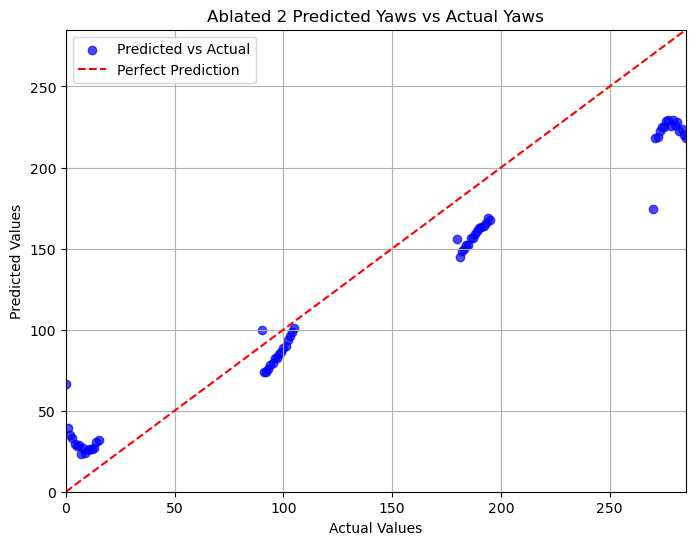

In [12]:
average_predictions = np.load(f'logs/ablate_{ablate_idx}_yaw_predictions.pkl', allow_pickle=True)

plt.figure(figsize=(8, 6))
plt.scatter(average_predictions.keys(), average_predictions.values(), alpha=0.7, color='blue', label='Predicted vs Actual')
plt.title(f'Ablated {ablate_idx} Predicted Yaws vs Actual Yaws')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([0, 285], [0, 285], 'r--', label='Perfect Prediction')  # Red dashed line for perfect prediction
plt.xlim([0, 285])
plt.ylim([0, 285])
plt.legend()
plt.grid(True)
plt.show()

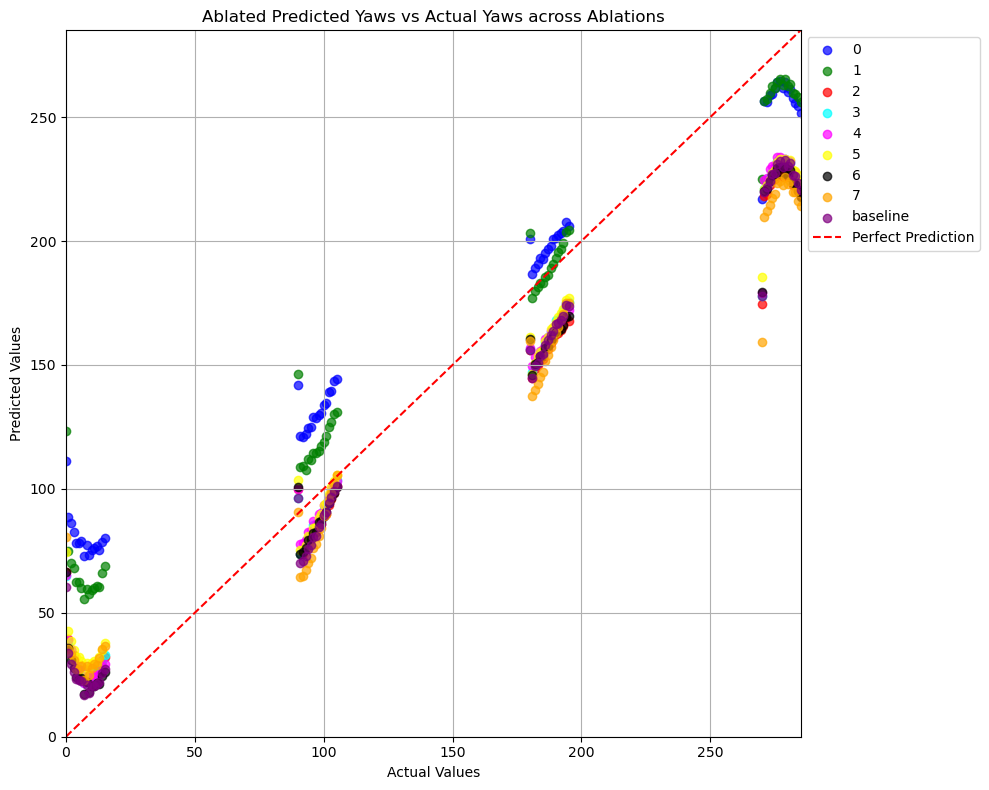

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data for 9 different conditions with different colors
ablations = list(range(8)) + ['baseline']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']

plt.figure(figsize=(10, 8))

for idx, color in zip(ablations, colors):
    try:
        average_predictions = np.load(f'logs/ablate_{idx}_yaw_predictions.pkl', allow_pickle=True)
    except:
        continue
    plt.scatter(average_predictions.keys(), average_predictions.values(), alpha=0.7, color=color, label=idx)

plt.title('Ablated Predicted Yaws vs Actual Yaws across Ablations')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([0, 285], [0, 285], 'r--', label='Perfect Prediction')  # Red dashed line for perfect prediction
plt.xlim([0, 285])
plt.ylim([0, 285])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

